### Analysis of tweets to check whether it is related to the true disaster event or it is referrring to movie reviews,jokes or something irrelevant

#### Import the required libraries

In [51]:
import pandas as pd
import nltk
import re
import string 
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
import operator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#### Load the dataset

In [2]:
dataset = pd.read_csv(r'C:\Users\1085679\Documents\ML_Practice\socialmedia-disaster-tweets-DFE.csv',encoding='ISO-8859-1')

#### Analysis of data provided

In [3]:
dataset=dataset[dataset['choose_one']!="Can't Decide"]
print(dataset.shape)
print(dataset.columns)
print(dataset.dtypes.unique())

(10860, 13)
Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'choose_one', 'choose_one:confidence',
       'choose_one_gold', 'keyword', 'location', 'text', 'tweetid', 'userid'],
      dtype='object')
[dtype('int64') dtype('bool') dtype('O') dtype('float64')]


#### Dataset contains 13 features and 10876 samples and contains four different datatype columns

In [4]:
categorical_columns = dataset.select_dtypes(include=['object','bool']).columns
numerical_columns = dataset.select_dtypes(include=['float64','int64']).columns
df_categorical = dataset[categorical_columns]
df_numerical = dataset[numerical_columns]
print(len(categorical_columns))
print(len(numerical_columns))

8
5


#### There are 8 categorical columns and 5 numerical columns in the dataset

In [5]:
print(dataset[categorical_columns].isnull().sum())
print(dataset[numerical_columns].isnull().sum())

_golden                  0
_unit_state              0
_last_judgment_at       84
choose_one               0
choose_one_gold      10773
keyword                 87
location              3632
text                     0
dtype: int64
_unit_id                  0
_trusted_judgments        0
choose_one:confidence     0
tweetid                   0
userid                   87
dtype: int64


#### Of 10876 samples, choose one gold column contains 99.2% null values and location contains 33.5%  null values. 
#### Keyword, userid, last_judgment_at contains <1% null values

#### Drop the column which has more than 30% of null values and replace the null values in other categorical columns with ffill


In [6]:
null_count_categorical = dict(dataset[categorical_columns].isnull().sum())
for key,val in null_count_categorical.items():
    if val>0.3*len(dataset):
        df_categorical.drop(key,axis=1,inplace=True)
    elif val>1:
        df_categorical[key].fillna(method='ffill',inplace=True)
        df_categorical[key].fillna(method='bfill',inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Repeat the same steps as above for numerical columns

In [7]:
null_count_numerical = dict(dataset[numerical_columns].isnull().sum())
for key,val in null_count_numerical.items():
    if val>0.3*len(dataset):
        df_numerical.drop(key,axis=1,inplace=True)
    elif val>1:
        df_numerical[key].fillna(df_numerical['_unit_id'].mode()[0],inplace=True)
df_numerical.drop('_unit_id',inplace=True,axis=1)
df_categorical.drop(['_golden','_unit_state','_last_judgment_at'],inplace=True,axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Remove unnecessary symbols from text and convert it to lowercase

In [8]:
punctuation = list(string.punctuation)
punctuation.extend(['\n','\t'])
def clean_text(txt):
    'Remove unnecessary characters'
    txt = re.sub(r'[^\w]',' ',txt)
    txt = txt.encode('ascii','ignore').decode('utf-8')
    'Remove extra spaces'
    txt = re.sub(r'\s{2,}',' ',txt)
    'Convert text to lowercase'
    txt = txt.lower()
#     print(txt)
    return txt
    'need to find something for spelling correction'
text = "Am i n't sup1po@sed to b>.e in ??>! ‚ÃƒÂ‚Ã‚Â¿s written notice to the Supplier to do so "
text=clean_text(text)

#### Lemmatization of each word

In [9]:
def word_lemmatize(sent):
    words = [word for word in nltk.word_tokenize(sent)] 
    pos_tagged_words = nltk.pos_tag(words)
#     print(pos_tagged_words)
    def pos_template(tag):
        if tag.startswith('R'):
            return wordnet.ADV
        elif tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        else:
            return wordnet.NOUN
#     return nltk.WordNetLemmatizer.lemmatize('running',pos=pos_template('NNS'))
    return ' '.join([nltk.WordNetLemmatizer().lemmatize(word,pos=pos_template(tag)) for word,tag in pos_tagged_words])
# word_lemmatize('cats running ran cactus cactuses cacti community communities')

In [10]:
temp=[]
for i in df_categorical.text:
    temp.append(word_lemmatize(clean_text(i)))
df_categorical['text']=temp

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### Count Vectorizing the text data (Bag of Words)

In [12]:
cvec = CountVectorizer(analyzer='word')
bow = cvec.fit_transform(df_categorical.text)
new_df = pd.DataFrame(bow.toarray())
# print(cvec.vocabulary_)
new_df.columns = cvec.get_feature_names()

#### Visualising the embeddings

#### Dimension of the data is reduced using PCA for visualisation

In [13]:
from sklearn.decomposition import PCA
pca= PCA(n_components=2)
data = pd.DataFrame(pca.fit_transform(new_df))
data.columns=['x','y']
print('variance ratio')
print(pca.explained_variance_ratio_)
data['result']=df_categorical['choose_one'].copy()
import seaborn as sns
sns.scatterplot('x','y',data=data,hue='result')

variance ratio
[0.06248598 0.0342184 ]


#### Encode the output labels

In [14]:
t={'Relevant':1,'Not Relevant':0}
y=df_categorical.choose_one.apply(lambda x:t[x])

#### Dropping unnecessary columns

In [15]:
# df_categorical.drop(['text','keyword','choose_one'],axis=1,inplace=True)
df_numerical.drop(['tweetid','userid'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Combine the processed categorical and numerical dataframes

In [ ]:
# df_categorical.reset_index(drop=True,inplace=True)
# df_numerical.reset_index(drop=True,inplace=True)
# new_df.reset_index(drop=True,inplace=True)
x = pd.concat([df_numerical,new_df],axis=1)
traindatax,testdatax,traindatay,testdatay = train_test_split(new_df,y,test_size=0.33,random_state=42)

#### Training model using classifier

In [42]:
lr = LogisticRegression()
lr.fit(traindatax,traindatay)
print(lr.score(testdatax,testdatay))

C:\Users\1085679\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.798828125


#### For classification problems, accuracy cannot be considered always, especially when the dataset is biased.
#### It is necessary to analyse the model using confusion matrix

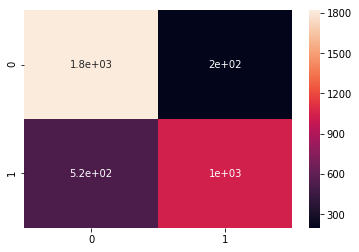

In [43]:
y_pred = lr.predict(testdatax)
# print(metrics.classification_report(testdatay,y_pred))
cm = metrics.confusion_matrix(testdatay,y_pred)
sns.heatmap(cm,annot=True)

#### From the confusion matrix, it is understood, 300 sentences referring to acutal disaster is predicted as irrelevant

#### Obtaining the features which most contributes to disaster and irrelevant classification

In [44]:
d = cvec.get_feature_names()
f = lr.coef_.tolist()[0]
e = list(zip(d,f))
words_most_contribute_to_disaster = sorted(e,key=operator.itemgetter(1),reverse=True)[:9]
words_most_contribute_to_irelevant = sorted(e,key=operator.itemgetter(1),reverse=True)[-9:]

In [45]:
w,c=zip(*words_most_contribute_to_irelevant)
dw,dc = zip(*words_most_contribute_to_disaster)
result = pd.DataFrame({'Words_related_to_Disaster':dw,'Words_related_to_Irelevant':w})
result

,Words_related_to_Disaster,Words_related_to_Irelevant
0,fire,your
1,in,he
2,hiroshima,bag
3,storm,youtube
4,wildfire,scream
5,train,you
6,kill,full
7,flood,new
8,california,my


#### Visualizing the contribution of each word to the respective categories

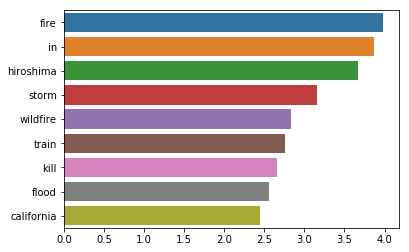

In [46]:
# sns.bar()
temp = dict(words_most_contribute_to_disaster)
sns.barplot(list(temp.values()),list(temp.keys()))

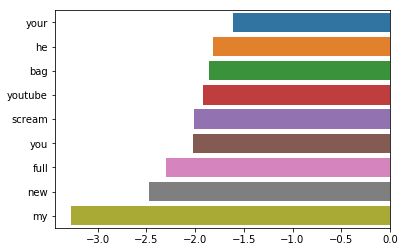

In [47]:
temp = dict(words_most_contribute_to_irelevant)
sns.barplot(list(temp.values()),list(temp.keys()))

#### Another approach for transforming text to numerical value is TF-IDF

In [49]:
tvec = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_vectors=tvec.fit_transform(bow).toarray()
new_df = pd.DataFrame(tfidf_vectors)

TypeError: __init__() got an unexpected keyword argument 'ngram_range'

In [ ]:
tvec = TfidfVectorizer(ngram_range=(1,2))
tfidf_vectors=tvec.fit_transform(df_categorical.text).toarray()
new_df = pd.DataFrame(tfidf_vectors)
